In [1]:
# Import Base Python Libraries used in this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from datetime import datetime, timedelta
from numpy import array
from numpy import split
from math import sqrt

# Import Libraries for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Import Libraries for classic AI Model
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from skforecast.model_selection import grid_search_forecaster

# Import LSTM Model libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

# Import ARIMA libraries
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Turn off Warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Dataset
home_df = pd.read_csv('HomeC.csv')

# Drop last row which has bad data
home_df = home_df[:len(home_df)-1]

# Rename column to make it easier to work with
home_df.rename(columns={'Solar [kW]': 'Solar', }, inplace=True)

# Create a DateTime column from the current Unix time column
home_df['Datetime'] = pd.to_datetime(home_df['time'], unit='s', errors='coerce') - timedelta(hours=5)
home_df['Datetime'] = pd.date_range(start=home_df['Datetime'].min(), periods=len(home_df), freq='min')

# Backfill cloudCover data that is incorrectly filled with 'cloudCover'
home_df['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True) 
home_df['cloudCover'] = home_df['cloudCover'].astype('float') 
home_df.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Datetime
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:00:00
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:01:00
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:02:00
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:03:00
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:04:00


In [3]:
# Select key columns for modeling based on previous data exploration
features = ['time', 'Datetime', 'Solar', 'temperature', 'visibility', 'cloudCover', 'windSpeed', 'humidity']
solar_df = home_df[features]

# Output Solar Dataframe
solar_df.head()


,time,Datetime,Solar,temperature,visibility,cloudCover,windSpeed,humidity
0,1451624400,2016-01-01 00:00:00,0.003483,36.14,10.0,0.75,9.18,0.62
1,1451624401,2016-01-01 00:01:00,0.003467,36.14,10.0,0.75,9.18,0.62
2,1451624402,2016-01-01 00:02:00,0.003467,36.14,10.0,0.75,9.18,0.62
3,1451624403,2016-01-01 00:03:00,0.003483,36.14,10.0,0.75,9.18,0.62
4,1451624404,2016-01-01 00:04:00,0.003467,36.14,10.0,0.75,9.18,0.62


In [4]:
hour_df = solar_df.groupby('Datetime')['Solar', 'temperature', 'visibility'].sum()
hour_df = hour_df.groupby(pd.Grouper(freq='60Min', label='right')).sum()
hour_df

,Solar,temperature,visibility
Datetime,,,
2016-01-01 01:00:00,0.198417,2167.86,600.00
2016-01-01 02:00:00,0.205300,2150.32,600.00
2016-01-01 03:00:00,0.206900,2123.10,600.00
2016-01-01 04:00:00,0.206850,2116.92,600.00
2016-01-01 05:00:00,0.206350,2127.10,600.00
...,...,...,...
2016-12-15 19:00:00,0.248250,2219.40,562.80
2016-12-15 20:00:00,0.246533,2255.05,531.32
2016-12-15 21:00:00,0.248483,2185.76,514.58


# Random Forest Regression Model

Train dates : 2016-01-01 01:00:00 --- 2016-10-06 23:00:00  (n=6719)
Test dates  : 2016-10-07 00:00:00 --- 2016-12-15 23:00:00  (n=1680)


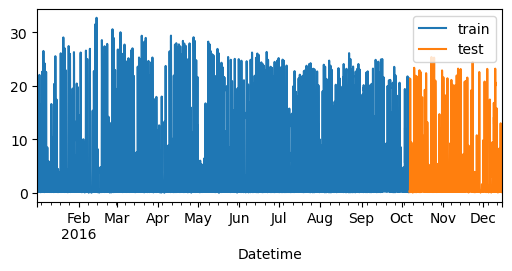

In [5]:
# Split data into 75% Training and 25% Testing
steps = round(len(hour_df) * .20)
data_train = hour_df[:-steps]
data_test = hour_df[-steps:]

# Check dataset lengths
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plot Datasets to vizualize and confirm split
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['Solar'].plot(ax=ax, label='train')
data_test['Solar'].plot(ax=ax, label='test')
ax.legend();

In [6]:
# Use SK Forecaster to perform multi-step forecasting
#  https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12  # Previous hours of data to consider in model
             )

forecaster.fit(y=data_train['Solar'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2016-01-01 01:00:00'), Timestamp('2016-10-06 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: 60T 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-02-20 17:42:59 
Last fit date: 2024-02-20 17:43:08 
Skforecast version

Test error (MSE): 133.6811216450262


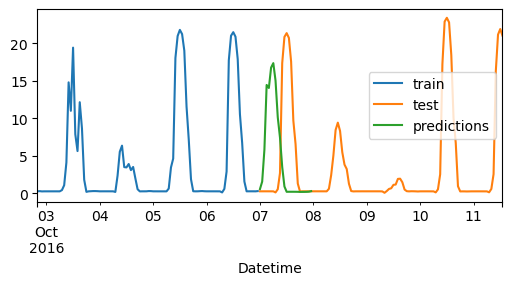

In [7]:
# Predict 24 Hours into the future
steps = 24
predictions = forecaster.predict(steps=steps)

# Plot predictions versus test data
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['Solar'][-100:].plot(ax=ax, label='train')
data_test['Solar'][:110].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Calculate MSE
error_mse = mean_squared_error(
                y_true = data_test['Solar'][:steps],
                y_pred = predictions
            )

print(f"Test error (MSE): {error_mse}")


# LSTM Modeling

In [9]:
# Split dataset into 80% training and 20% testing
data_all = hour_df.reset_index()
split = round(len(data_all)*.20)
data_train = data_all[:-split]
data_test = data_all[-split:]

#reset the indices 
#data_train = data_train.reset_index()
#data_test = data_test.reset_index()

# Duplicate the first row and add it to the training data - This will make it divisible by 24
prepend_data = data_train.iloc[0:1]
data_train = pd.concat([pd.DataFrame(prepend_data), data_train], ignore_index=True)
data_train['Datetime'][0:1] = '2016-01-01 00:00:00'

# Check dataset lengths
print("Train Data : ", len(data_train))
print("Test Data  : ", len(data_test))


Train Data :  6720
Test Data  :  1680


In [10]:
# Build Train and Test Datasets
features = ['Solar', 'temperature', 'visibility']
sequence = 24
pred_steps = 24

train = []
test = []

# Create a Sequence List for TRAIN data
for i in range(0,round(len(data_train)/sequence)):
    start = i*sequence
    # Build array of arrays
    train.append(data_train[features].iloc[start:start + sequence].to_numpy())
    
# Create a Sequence List for TEST data 
for i in range(0,round(len(data_test)/sequence)):
    start = i*sequence
    # Build array of arrays
    test.append(data_test[features].iloc[start:start + sequence].to_numpy())
    

# Convert lists to numpy arrays
test = np.array(test, dtype=object).astype(np.float32)
train = np.array(train, dtype=object).astype(np.float32)

print('Test Shape: ', test.shape)
print('Train Shape: ', train.shape)

Test Shape:  (70, 24, 3)
Train Shape:  (280, 24, 3)


In [15]:
# evaluate predictions against actual values
def evaluate_prediction(actual, predicted):
    # Flatten Predicted Values
    pred_values = []
    for i in range(len(predictions)):
        for j in range(len(predictions[i])):
            pred_values.append(predictions[i][j])

    # Calculate Mean Squared Error and Root Mean Squared error and print results
    mse = mean_squared_error(actual, pred_values) # mean squared error
    rmse = np.sqrt(mse) # root mean squared error    
    print('Mean Squared Error: ', mse)
    print('Root Mean Squared Error: ', rmse)
    
    # Plot the predicted data vs. the actual data (Limit first 200 values)
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(actual.index[:200], actual[:200], label = 'Actual Value')
    plt.plot(actual.index[:200], pred_values[:200], label = 'Predicted Value')
    plt.title('Solar Generation Predictions - First 200 Points', fontsize=22, fontweight='bold')
    plt.ylabel('Kilowatts')
    plt.xlabel('Timestep')
    plt.legend()
    plt.show()

# convert into inputs and outputs
def to_supervised(train, n_input, n_out=24):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# Build a BASE LSTM Model
def build_base_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    
    # define parameters
    verbose, epochs, batch_size = 0, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
   
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    
    # fit model
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# Build a LSTM with Encoder/Decoder layers
def build_enddec_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# Build a LSTM with CNN layers
def build_cnn_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    
    # make the prediction
    yhat = model.predict(input_x, verbose=0)
    
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def predict(train, test, n_input, model):
    # history is a list of hourly data
    history = [x for x in train]
    
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        
        # store the predictions
        predictions.append(yhat_sequence)
        
        # get real observation and add to history for predicting
        history.append(test[i, :])
    # return predictions
    predictions = array(predictions)
    return predictions


Mean Squared Error:  22.81324235135686
Root Mean Squared Error:  4.776321005895317


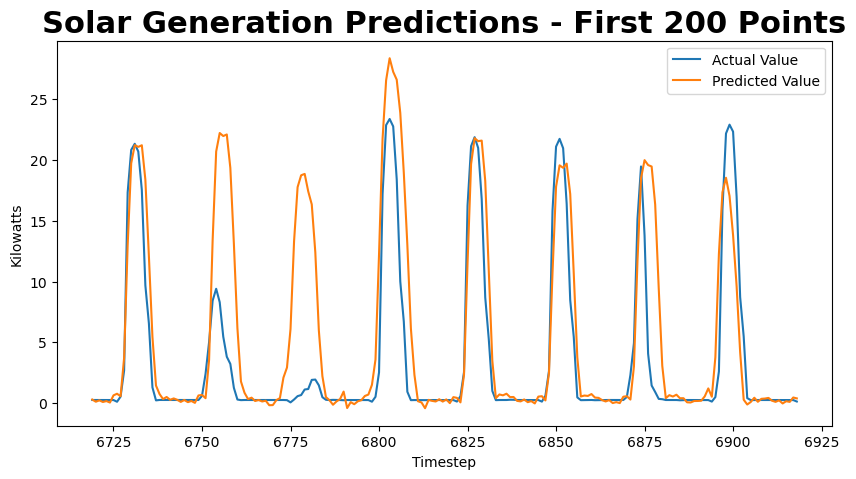

In [16]:
n_input = 24

# Build a base LSTM model
model = build_base_model(train, n_input)
predictions = predict(train, test, n_input, model)
evaluate_prediction(data_test['Solar'], predictions)

Mean Squared Error:  21.696811860751342
Root Mean Squared Error:  4.657983669008656


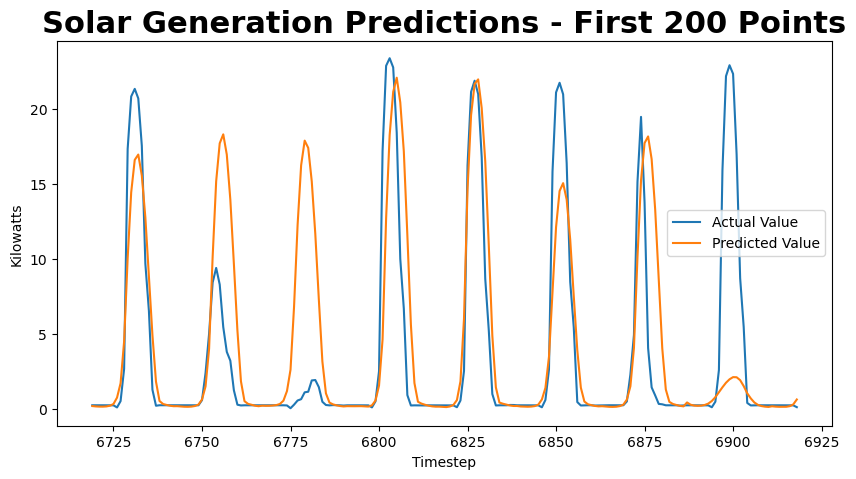

In [17]:
# Build a LSTM model with Encoder/Decoder layers
model = build_enddec_model(train, n_input)
predictions = predict(train, test, n_input, model)
evaluate_prediction(data_test['Solar'], predictions)

Mean Squared Error:  22.968248765331495
Root Mean Squared Error:  4.792520085021188


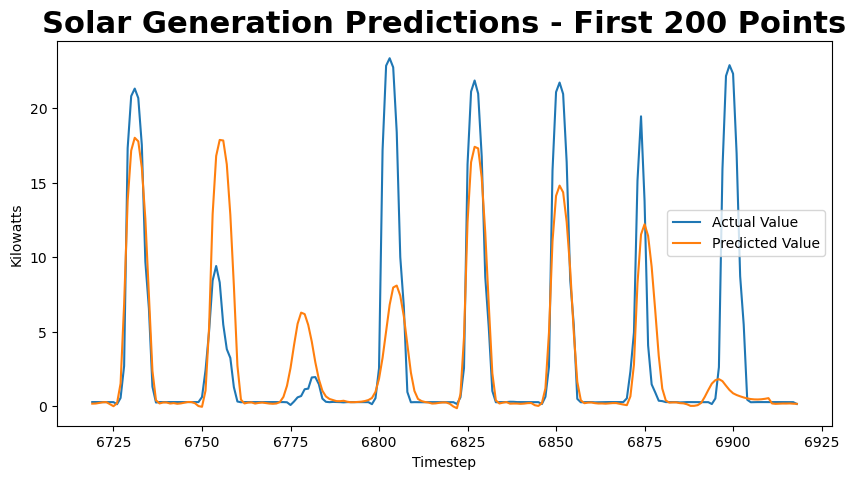

In [18]:
# Build a LSTM model with Encoder/Decoder layers
model = build_cnn_model(train, n_input)
predictions = predict(train, test, n_input, model)
evaluate_prediction(data_test['Solar'], predictions)

# ARIMA Model

In [19]:
# Perform an ADF test to check if Solar Power Generation over time is stationary  
adf_results = adfuller(hour_df['Solar'], autolag='AIC')

# Extract the results, and print them out.
#     If resulting p-value is less than .05, we can conclude that time series is stationary
output = pd.Series(adf_results[0:4], index = ['Test Statistic', 'p-value', 'Lags Used', 'Number of Observation Used'])
print("Augmented Dickey Fuller test Results: \n\n{}".format(output))


Augmented Dickey Fuller test Results: 

Test Statistic               -1.105849e+01
p-value                       4.876362e-20
Lags Used                     2.900000e+01
Number of Observation Used    8.369000e+03
dtype: float64


The p-value is nearly zero, so the data is stationary

Number of point in full data series : 8399
Number of points in training data: 6719
Number of points in testing data: 1680


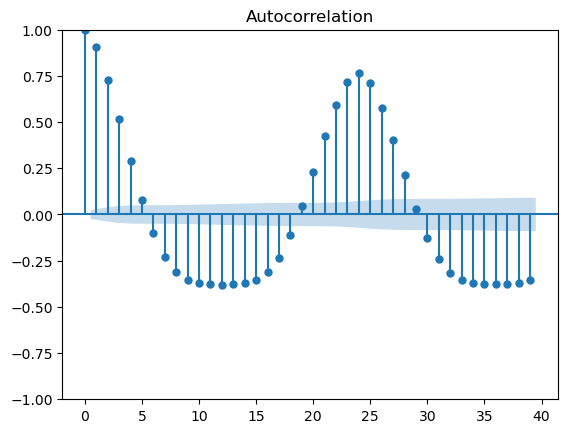

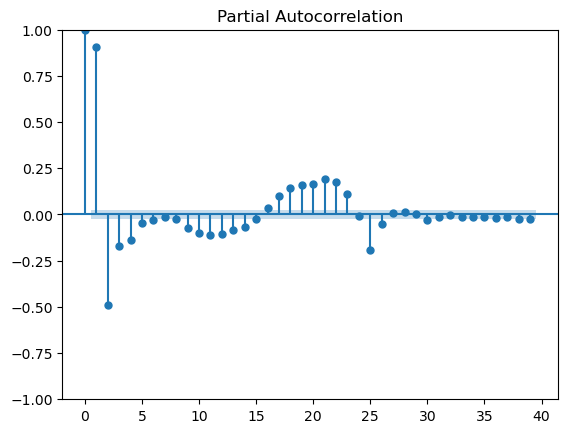

In [20]:
# Define datasets to use in ARIMA model
# Split dataset into 80% training and 20% testing
solar_all = hour_df.reset_index()['Solar']
split = round(len(solar_all)*.20)
solar_train = solar_all[:-split]
solar_test = solar_all[-split:]



# print the  number of data points in the full dataset, training and test series
print("Number of point in full data series :", len(solar_all))
print("Number of points in training data:", len(solar_train))
print("Number of points in testing data:", len(solar_test))


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(solar_train)

pacf_original = plot_pacf(solar_train)

In [21]:
# initialize the ARIMA model with the order (2,1,1) on the training data
model = ARIMA(solar_train, order = (2,1,1))

# fit the ARIMA Model to the training data
fitted_model = model.fit()

# print the Akaike Information Criterion (AIC) value for the fitted model
print("Akaike Information Criterion :", fitted_model.aic)

Akaike Information Criterion : 34113.40654030405


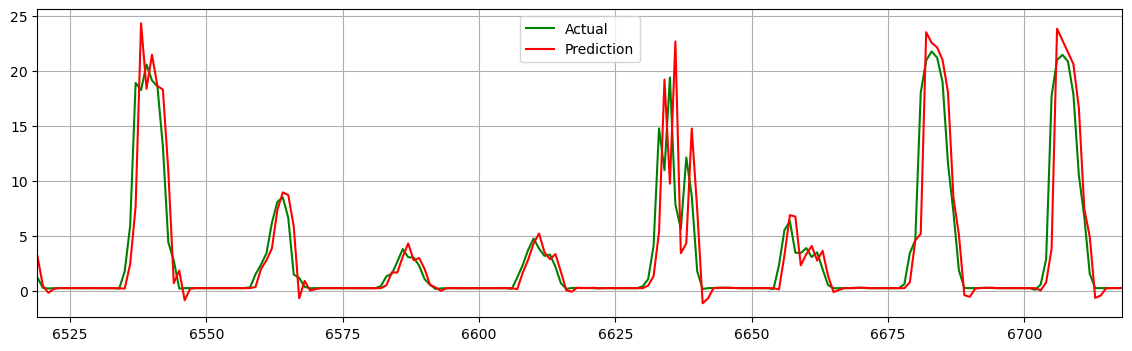

                               SARIMAX Results                                
Dep. Variable:                  Solar   No. Observations:                 6719
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -17052.703
Date:                Tue, 20 Feb 2024   AIC                          34113.407
Time:                        18:00:57   BIC                          34140.657
Sample:                             0   HQIC                         34122.816
                               - 6719                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2926      0.307      0.953      0.341      -0.309       0.895
ar.L2          0.0774      0.126      0.613      0.540      -0.170       0.325
ma.L1          0.1151      0.307      0.374      0.7

In [22]:
# Plot the Last 200 data points of Actual data and model predictions
plt.figure(figsize=(14,4))
plt.plot(solar_train[-200:], c = 'green', label = 'Actual')
plt.plot(fitted_model.predict(dynamic=False)[-200:], c = 'red',  label = 'Prediction')
plt.legend()
plt.grid()
plt.margins(x=0)
plt.show()

# print the summary of the fitted model
print(fitted_model.summary())

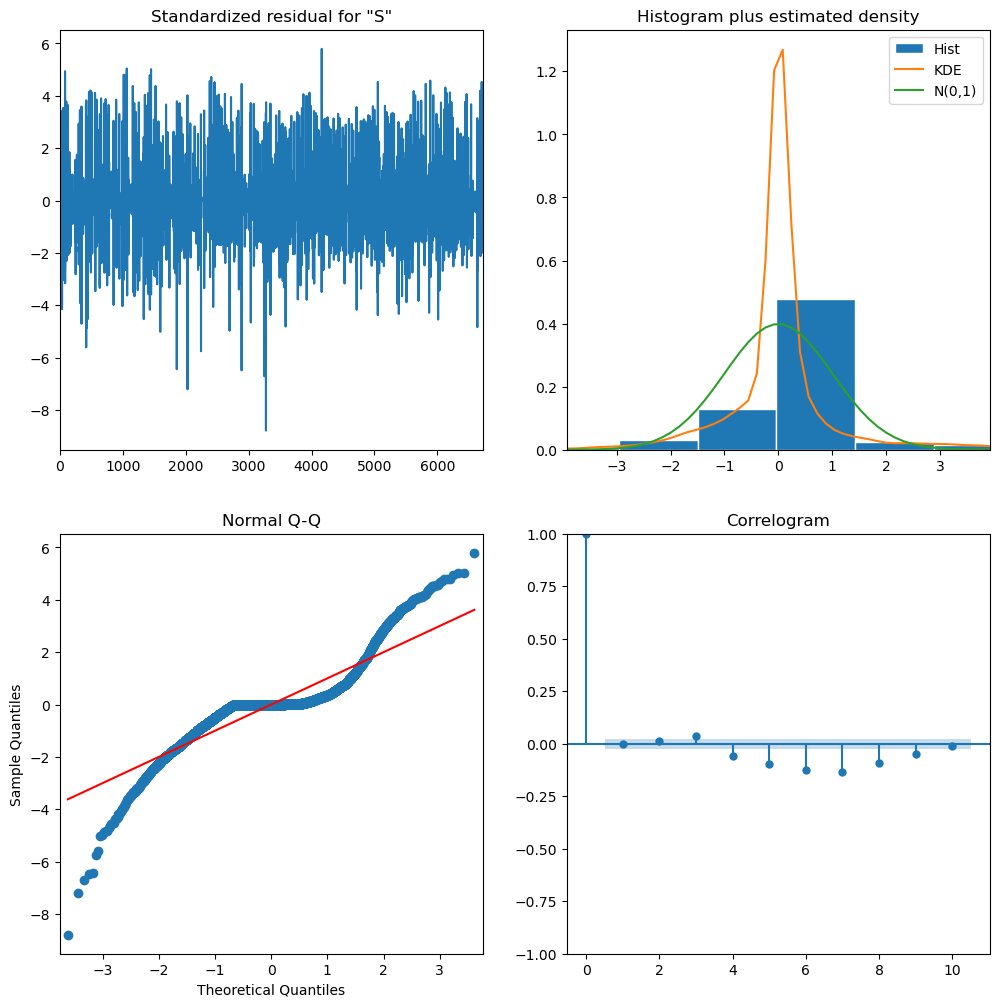

In [23]:
fitted_model.plot_diagnostics(figsize=(12,12))
plt.show()

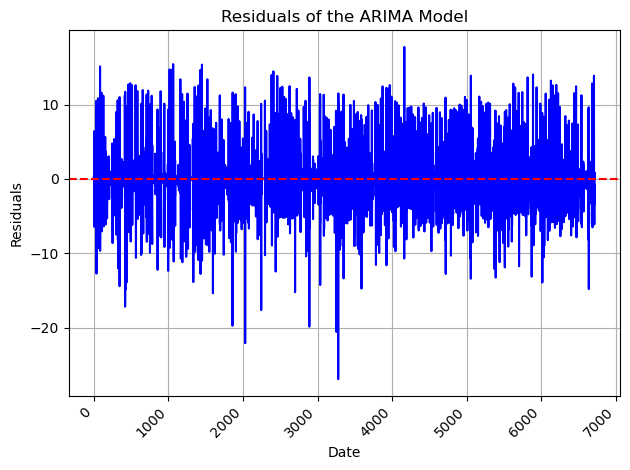

In [24]:
# Extract the residuals
residuals = fitted_model.resid

#plotting the residuals
plt.plot(figsize=(14,4))
plt.plot(residuals , color ='blue')
plt.xticks(rotation = 45, ha ='right')
plt.title("Residuals of the ARIMA Model")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.axhline(y=0, color= 'r', linestyle = "--") # Add a horizontal line at 0 for reference
plt.grid(True)
plt.tight_layout()
plt.show()

MSE (Mean Squared Error) for Single Forecast ARIMA Model: 41.490
RMSE (Root Mean Squared Error) for Single Forecast ARIMA Model: 6.441
 ******************************************************** PLOT *********************************************


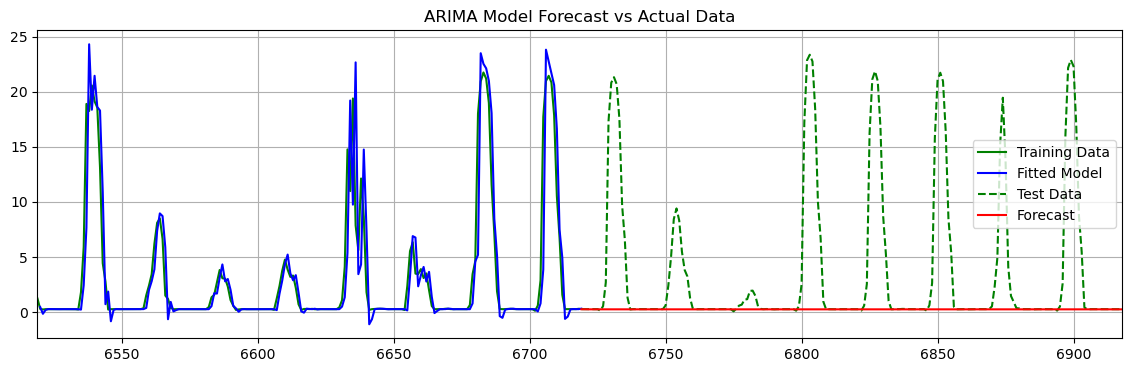

In [25]:
# calculate the starting index for appending based on the length of train data
start_append_index = len(solar_train)
# append one new observations from the daily_data to the fitted model without refitting the model
new_fit = fitted_model.append(solar_all[start_append_index:start_append_index+1], refit = False)
# forecast the values for the test set
forecast = new_fit.forecast(len(solar_test))
# get the confidence intervals for the forecast at the 95% level
confidence = new_fit.get_forecast(len(solar_test)).conf_int(0.05)


# calculate and print the error metrics
mse = mean_squared_error(solar_test, forecast)
rmse = np.sqrt(mse)

print(f'MSE (Mean Squared Error) for Single Forecast ARIMA Model: {mse:.3f}')
print(f'RMSE (Root Mean Squared Error) for Single Forecast ARIMA Model: {rmse:.3f}')
print(" ******************************************************** PLOT *********************************************")

# plotting the training data, fitted model , test data , forecast and conidence intervals
plt.figure(figsize = (14,4))
plt.plot(solar_train[-200:], c = 'green', label = "Training Data")
plt.plot(new_fit.predict(dynamic=False)[-200:], c = 'blue', label = 'Fitted Model')
plt.plot(solar_test[:200].index, solar_test[:200], c = 'green', label = 'Test Data', linestyle = '--')
plt.plot(solar_test[:200].index , forecast[:200], c = 'red', label = 'Forecast')
#plt.fill_between(solar_test.index[200], confidence.iloc[:,0], confidence.iloc[:,1], color ='k', alpha =.15, label = '95% Confidence Interval')

plt.title("ARIMA Model Forecast vs Actual Data")
plt.legend()
plt.grid()
plt.margins(x =0)
plt.show()